In [60]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
import numpy as np

#import F
from torch.nn import functional as F

In [61]:
# Set device to cuda 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [62]:
from torchvision import datasets

In [63]:
# transforms, convert to greyscale, convert to tensor, normalize and move to cuda
trainTransforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.to(device))
])

validTransforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.to(device))
])

In [64]:
trainFolder = 'train'
trainDataset = datasets.ImageFolder(trainFolder, transform=trainTransforms)

# Select 1000 images only to train
#trainDataset = torch.utils.data.Subset(trainDataset, np.random.choice(len(trainDataset), 1000, replace=False))

validFolder = 'val'
validDataset = datasets.ImageFolder(validFolder, transform=validTransforms)

# Select 100 images only to validate
#validDataset = torch.utils.data.Subset(validDataset, np.random.choice(len(validDataset), 100, replace=False))

In [65]:
print('Train dataset:', len(trainDataset))
print('Valid dataset:', len(validDataset))

Train dataset: 4739
Valid dataset: 500


In [66]:
#Import DataLoader
from torch.utils.data import DataLoader
batchSize = 16
trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
validLoader = DataLoader(validDataset, batch_size=batchSize, shuffle=True)   

In [67]:
class VariationalAutoEncoder(nn.Module):
    
    def __init__(self):
        super(VariationalAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        
        # mean and variance for the latent space
        self.fc1 = nn.Linear(256*16*16, 256)
        self.fc2 = nn.Linear(256*16*16, 256)
        
        
        #define the decoder
        self.decoder = nn.Sequential(
            nn.Linear(256, 512*8*8),
            nn.Unflatten(1, (512, 8, 8)),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(3),
            nn.Tanh()
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    # define the forward pass
    def forward(self, x):
        x = self.encoder(x.view(-1, 3, 512, 512))
        mu, logvar = self.fc1(x), self.fc2(x)
        z = self.reparameterize(mu, logvar)
        z = self.decoder(z.view(-1, 256))
        return z, mu, logvar
        
            

In [68]:
# print summary for input of size 512x512 and 3 channels
model = VariationalAutoEncoder().to(device)
from torchsummary import summary
summary(model, (3, 512, 512))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 65536]               --
|    └─Conv2d: 2-1                       [-1, 16, 512, 512]        448
|    └─ReLU: 2-2                         [-1, 16, 512, 512]        --
|    └─MaxPool2d: 2-3                    [-1, 16, 256, 256]        --
|    └─Conv2d: 2-4                       [-1, 32, 256, 256]        4,640
|    └─BatchNorm2d: 2-5                  [-1, 32, 256, 256]        64
|    └─ReLU: 2-6                         [-1, 32, 256, 256]        --
|    └─MaxPool2d: 2-7                    [-1, 32, 128, 128]        --
|    └─Conv2d: 2-8                       [-1, 64, 128, 128]        18,496
|    └─ReLU: 2-9                         [-1, 64, 128, 128]        --
|    └─MaxPool2d: 2-10                   [-1, 64, 64, 64]          --
|    └─Conv2d: 2-11                      [-1, 128, 64, 64]         73,856
|    └─ReLU: 2-12                        [-1, 128, 64, 64]         --
|  

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 65536]               --
|    └─Conv2d: 2-1                       [-1, 16, 512, 512]        448
|    └─ReLU: 2-2                         [-1, 16, 512, 512]        --
|    └─MaxPool2d: 2-3                    [-1, 16, 256, 256]        --
|    └─Conv2d: 2-4                       [-1, 32, 256, 256]        4,640
|    └─BatchNorm2d: 2-5                  [-1, 32, 256, 256]        64
|    └─ReLU: 2-6                         [-1, 32, 256, 256]        --
|    └─MaxPool2d: 2-7                    [-1, 32, 128, 128]        --
|    └─Conv2d: 2-8                       [-1, 64, 128, 128]        18,496
|    └─ReLU: 2-9                         [-1, 64, 128, 128]        --
|    └─MaxPool2d: 2-10                   [-1, 64, 64, 64]          --
|    └─Conv2d: 2-11                      [-1, 128, 64, 64]         73,856
|    └─ReLU: 2-12                        [-1, 128, 64, 64]         --
|  

In [69]:
# training batch
def trainBatch(data, model, optimiser, loss_function):
    model.train()
    data = data.to(device)
    optimiser.zero_grad()
    
    reconstructedBatch, mu, logvar = model(data)
    
    # calculate loss
    loss,mse,KLdivergence = loss_function(reconstructedBatch, data, mu, logvar)
    loss.backward()
    optimiser.step()
    
    return loss, mse, KLdivergence, logvar.mean(), mu.mean()

In [70]:
# validation batch
@torch.no_grad()
def validateBatch(data, model, loss_function):
    model.eval()
    data = data.to(device)
    
    reconstructedBatch, mu, logvar = model(data)
    
    # calculate loss
    loss,mse,KLdivergence = loss_function(reconstructedBatch, data, mu, logvar)
    
    return loss, mse, KLdivergence, logvar.mean(), mu.mean()

In [71]:
# def loss_function
def loss_function(reconstructedBatch, data, mu, logvar):
    reconstruction = F.mse_loss(reconstructedBatch, data.view(-1, 3, 512, 512), reduction='mean')
    KLdivergence = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()))
    
    return reconstruction + KLdivergence, reconstruction, KLdivergence

In [72]:
# Initialize model
model = VariationalAutoEncoder().to(device)

# Initialize optimizer
optimiser = torch.optim.Adam(model.parameters(), lr=0.0001)

EPOCH: 0.013  train_loss: 11373.001  train_kld: 11372.374  train_recon: 0.627  train_log_var: -0.831  train_mean: -0.021  (0.63s - 234.67s remaining)

EPOCH: 0.906  val_loss: 63.844  val_kld: 63.589  val_recon: 0.255  val_log_var: -0.002  val_mean: -0.004  (49.32s - 222.78s remaining))emaining))))))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 1.000  val_loss: 73.590  train_recon: 0.338  train_loss: 1832.576  train_kld: 1832.238  train_log_var: -0.652  val_log_var: -0.006  val_mean: -0.004  val_recon: 0.287  train_mean: -0.000  val_kld: 73.302  (49.50s - 198.01s remaining)


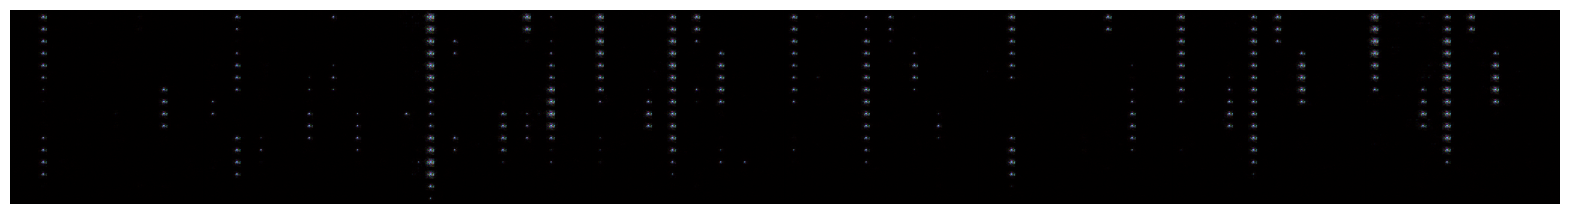

NameError: name 'plt' is not defined

In [73]:
#import report
from torch_snippets import Report

#import make_grid
from torchvision.utils import make_grid

# import show
from torch_snippets import show
n_epochs = 5
log = Report(n_epochs)
for epoch in range(n_epochs):
    N = len(trainLoader)
    for batchIndex , (image, label) in enumerate(trainLoader):
        loss, recon, KL, log_var, mean = trainBatch(image, model, optimiser, loss_function)
        
        pos = epoch + (batchIndex + 1)/N
        log.record(pos, train_loss = loss, train_kld=KL, train_recon=recon,train_log_var=log_var, train_mean=mean, end='\r')
    
    N = len(validLoader)
    for batchIndex, (image, label) in enumerate(validLoader):
        loss, recon, KL, log_var, mean = validateBatch(image, model, loss_function)
        
        pos = epoch + (batchIndex + 1)/N
        log.record(pos, val_loss = loss, val_kld=KL, val_recon=recon,val_log_var=log_var, val_mean=mean, end='\r') 
        
    log.report_avgs(epoch+1)
    
    # print 23 new generated images in 5x5 grid
    with torch.no_grad():
        # set grid size
        z = torch.randn(8, 256).to(device)
        sample = model.decoder(z).to(device)
        images = make_grid(sample.view(8,3,512,512)).permute(1,2,0)
        show(images)
        
    # print reconstructed images
    import matplotlib.pyplot as plt
    with torch.no_grad():
        for images, labels in validLoader:
            recon_images, _, _ = model(images.to(device))
            break

        N = 6
        fig, axes = plt.subplots(2,N, figsize=(20,5))
        for i in range(N):
            axes[0,i].imshow(images[i].cpu().numpy().transpose(1,2,0).squeeze())
            axes[1,i].imshow(recon_images[i].cpu().numpy().transpose(1,2,0).squeeze())
            
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

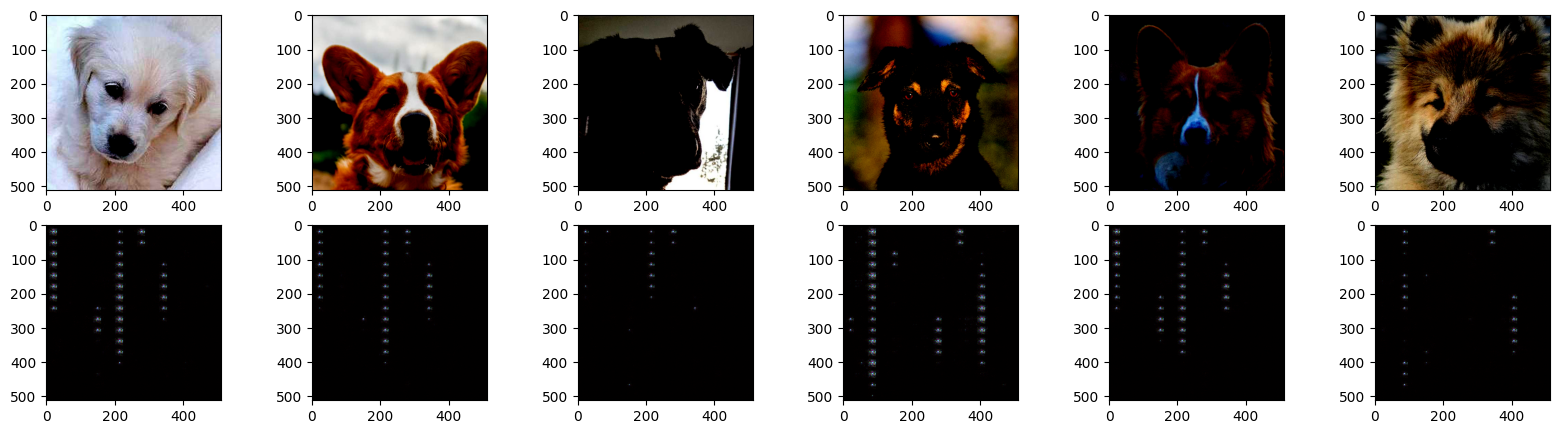

In [78]:
import matplotlib.pyplot as plt
with torch.no_grad():
    for images, labels in validLoader:
        recon_images, _, _ = model(images.to(device))
        break

    N = 6
    fig, axes = plt.subplots(2,N, figsize=(20,5))
    for i in range(N):
        axes[0,i].imshow(images[i].cpu().numpy().transpose(1,2,0).squeeze())
        axes[1,i].imshow(recon_images[i].cpu().numpy().transpose(1,2,0).squeeze())
        
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


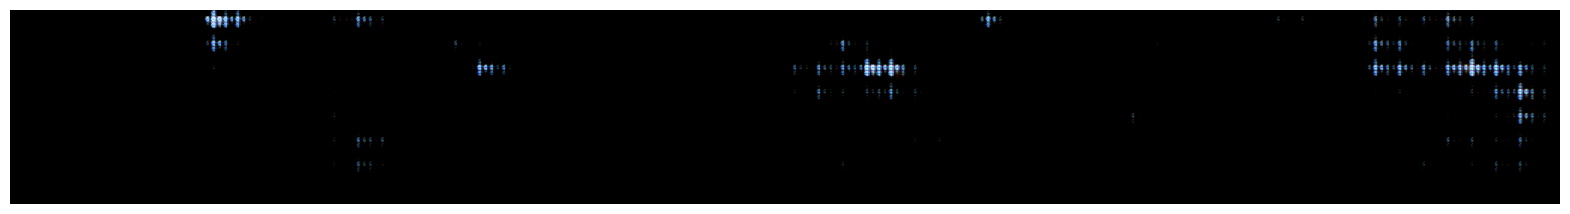

In [ ]:
with torch.no_grad():
 # set grid size
   # generate random latent vector from N(0,1)
    z = torch.randn(8, 256).to(device)
    sample = model.decoder(z).to(device)
    images = make_grid(sample.view(8,3,512,512)).permute(1,2,0)
    show(images)

100%|██████████| 106/106 [00:00<00:00, 8438.28it/s]


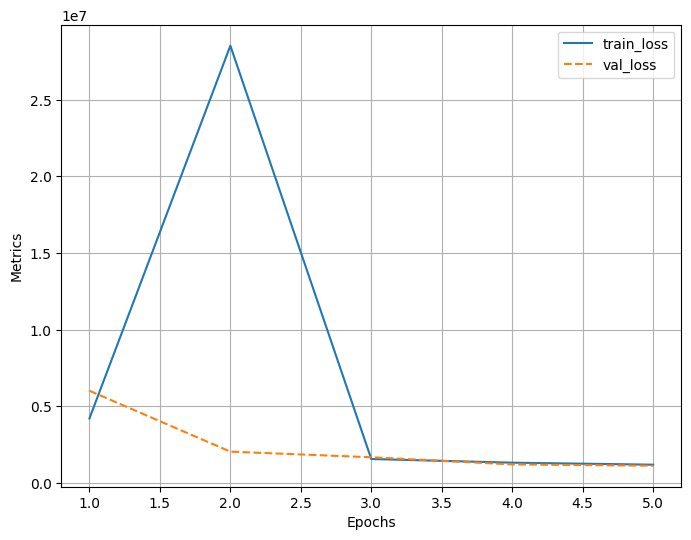

In [ ]:
log.plot_epochs(['train_loss', 'val_loss'])

100%|██████████| 106/106 [00:00<00:00, 10098.72it/s]


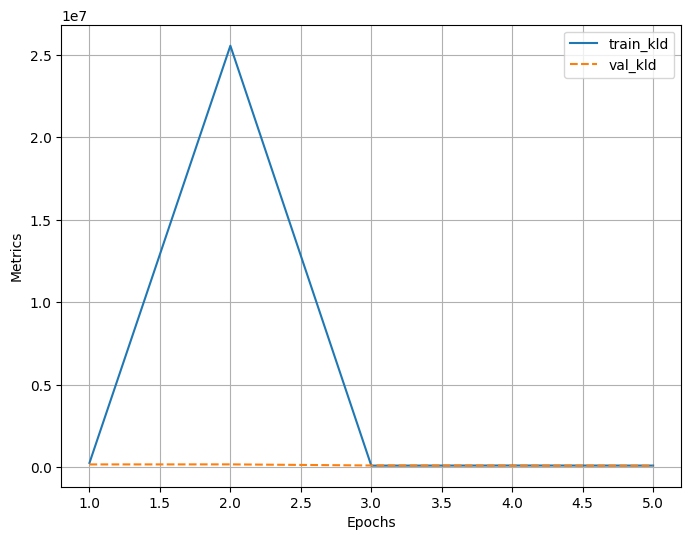

In [ ]:
# plot KL divergence
log.plot_epochs(['train_kld', 'val_kld'])